In [1]:
import os
import sys
# sys.path.append('/Users/evanli/Documents/EvanPys/Progress')
sys.path.append('/home/evanlee/PBMC_Hao')
from ADlasso2 import AD2_w_utils_test as ad

import numpy as np
import pandas as pd
from pathlib import Path
import scanpy as sc
import sklearn
from scipy.sparse import csr_matrix
from sklearn.metrics.cluster import adjusted_rand_score
import copy
import json
import time


In [2]:
# read in data with complete cells
adata = sc.read('/home/evanlee/PBMC_Hao/Hao_PBMC.h5ad')
print(adata.shape)  # row is cells, column is gene
# (161764, 20568)

sc.pp.log1p(adata)

(161764, 20568)


In [3]:
# Delete the 'neighbors' key from adata.uns
# if 'neighbors' already exists in adata.uns, error would occurs at sc.pp.neighbors
if 'neighbors' in adata.uns:
    del adata.uns['neighbors']

In [5]:
# PCA
sc.tl.pca(adata, svd_solver='arpack')

In [6]:
# neighborhood graph
sc.pp.neighbors(adata, n_neighbors=15)


/home/evanlee/.local/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/evanlee/.local/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/evanlee/.local/lib/python3.8/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: Th

/home/evanlee/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


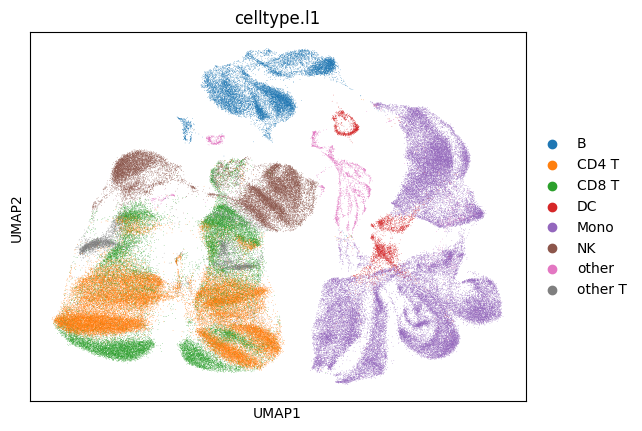

In [7]:
# UMAP
sc.tl.umap(adata)
sc.pl.umap(adata, color='celltype.l1')

/home/evanlee/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


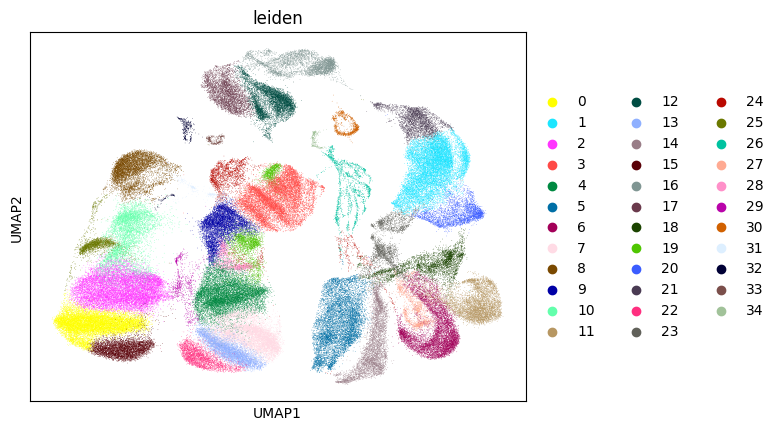

In [8]:
# Leiden clustering
sc.tl.leiden(adata)

# Plot Leiden UMAP
sc.pl.umap(adata, color='leiden')

In [9]:
# adata.write_h5ad('/home/evanlee/PBMC_Hao/Hao_PBMC_Leiden.h5ad')

In [10]:
adata.shape

(161764, 20568)

## ADlasso lambda tuning for each Leiden cluster

In [2]:
adata = sc.read('/home/evanlee/PBMC_Hao/Hao_PBMC_Leiden.h5ad')
adata.shape

(161764, 20568)

In [3]:
label = adata.obs['leiden'].tolist()
clusters = np.unique(label).tolist()

In [4]:
len(label)

161764

In [5]:
print(clusters)

['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '4', '5', '6', '7', '8', '9']


In [6]:
len(clusters)

35

In [7]:
def pipeline_ad2(data, celltype, label, alpha, output_path='', tuning_result=''):
    print('====================')
    print('Starting job for {}'.format(celltype))
    # Binary classification of a celltype
    celltype_label = [1 if x == celltype else 0 for x in label]
    # create index for a celltype
    celltype_indices = [idx for idx, label in enumerate(celltype_label) if label == 1]

    if tuning_result:
        os.chdir(tuning_result)  # /home/evanlee/Pancreas_AD2/Pancreas_result
        with open(f'./{celltype}/{celltype}_tuning.json') as f:
            print('Loading tuning result for {}'.format(celltype))
            result_dict = json.load(f)
            for key in result_dict.keys():
                result_dict[key] = np.array(result_dict[key])
    else:
        # a list of lambdas to test
        log_lmbd_range = np.linspace(np.log(1e-4), np.log(1), 25)
        lmbd_range = np.exp(log_lmbd_range)
        # Lambda tuning (can modify learning rate alpha)
        result_dict = ad.lambda_tuning_parallel(data.X, celltype_label, lmbd_range, alpha=alpha, device='cpu', n_jobs=13)

        # Export lambda tuning results as json
        os.chdir(output_path)
        output = dict()
        for key in result_dict.keys():
            output[key] = result_dict[key].tolist()
        with open('{}_tuning.json'.format(celltype), 'w') as f:
            json.dump(output, f)
    
        # Plot lambda tuning results
        Fig = ad.lambda_tuning_viz(result_dict, 'Feature_number', savepath='{}_feature_number.png'.format(celltype))
        Fig = ad.lambda_tuning_viz(result_dict, 'AUC', savepath='{}_AUC.png'.format(celltype))
        Fig = ad.lambda_tuning_viz(result_dict, 'loss_history', savepath='{}_loss_history.png'.format(celltype))
        Fig = ad.lambda_tuning_viz(result_dict, 'error_history', savepath='{}_error_history.png'.format(celltype))
        Fig = ad.lambda_tuning_viz(result_dict, 'Precision', savepath='{}_Precision.png'.format(celltype))
        Fig = ad.lambda_tuning_viz(result_dict, 'F1 score', savepath='{}_F1.png'.format(celltype))

    # Lambda decision k = 2
    os.chdir(output_path)
    opt_lmbd, fig = ad.lambda_decision(result_dict, k=2, savepath='{}_lambda_decision.png'.format(celltype))
    print('Optimal lambda: {}'.format(opt_lmbd))
    with open('{}_opt_lambda.txt'.format(celltype), 'w') as f:
        f.write(str(opt_lmbd) + '\n')

    return


In [ ]:
celltype = '0'

st = time.time()
# set learning rate alpha to 0.001
server_path = '/home/evanlee/PBMC_Hao/Leiden_alpha0.001'
pipeline_ad2(adata, celltype, label, alpha=0.001, output_path=server_path)
et = time.time()
print('{} Time elapsed: {} minutes.'.format(celltype, (et-st)/60))